In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rdtools
%matplotlib inline

from ImportData import df # previously imported and calculated data
# Note that new data report doesn't include met station, so we are using a file I saved from ~2019

# A lot of this follows from https://github.com/NREL/rdtools/blob/master/docs/degradation_and_soiling_example.ipynb

In [2]:
meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "tempco": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback',
        "a":-3.56,
        "b":-0.075,
        'delT':3} # a b delT for open rack glass/polymer module model

Text(0, 0.5, 'AC Power (W)')

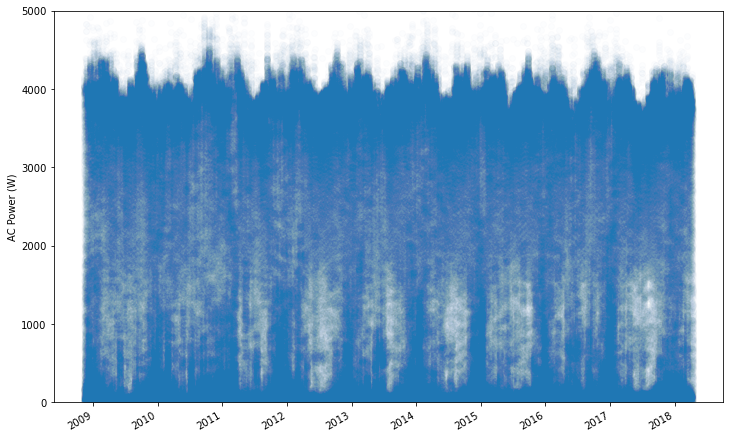

In [3]:
# AC power plot
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df.index, df.power, 'o', alpha=0.01)
ax.set_ylim(0,5000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)')

Text(0, 0.5, 'Normalized energy')

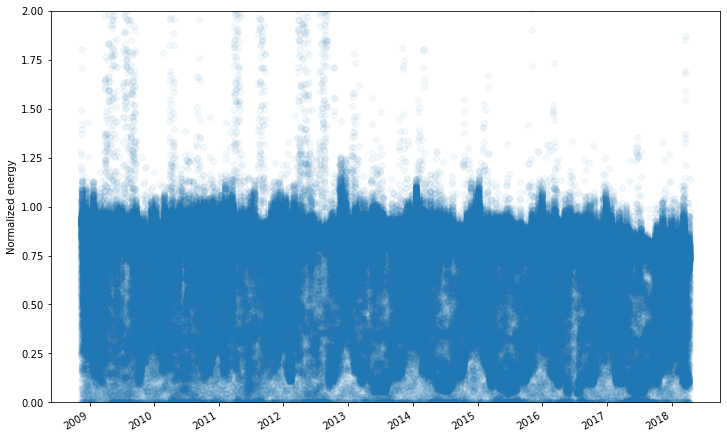

In [4]:
''' NORMALIZE - PVwatts is basically just a temp-corrected PR, but at least its a compact function for doing so'''
pvwatts_kws = {"poa_global" : df.poa,
              "power_dc_rated" : meta['pdc'],
              "temperature_cell" : df.Tcell,
              "poa_global_ref" : 1000,
              "temperature_cell_ref": 25,
              "gamma_pdc" : meta['tempco']}
normalized, insolation = rdtools.normalize_with_pvwatts(df.energy, pvwatts_kws)
df['normalized'] = normalized
df['insolation'] = insolation
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(normalized.index, normalized, 'o', ALPHA = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')

Text(0, 0.5, 'Normalized energy')

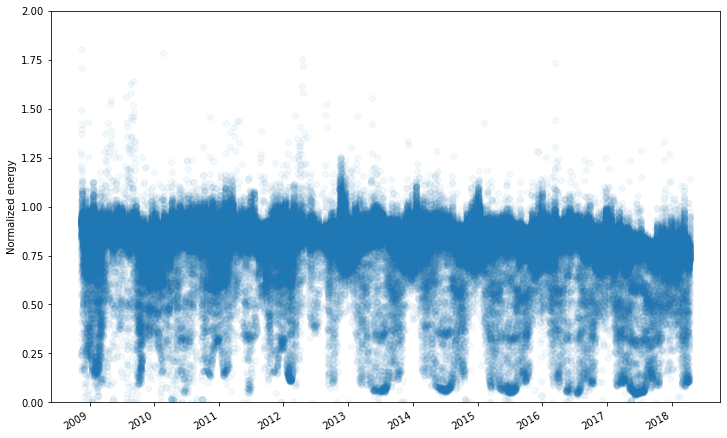

In [5]:
''' FILTER '''
nz_mask = (df['normalized'] > 0)
poa_mask = rdtools.poa_filter(df['poa'])
tcell_mask = rdtools.tcell_filter(df["Tcell"])
clip_mask = rdtools.clip_filter(df['power'])

filtered = df[nz_mask & poa_mask & tcell_mask & clip_mask]  # 895k -> 313k
filtered = filtered[['insolation','normalized']]
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(filtered.index, filtered.normalized, 'o', alpha=0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')

Text(0, 0.5, 'Normalized energy')

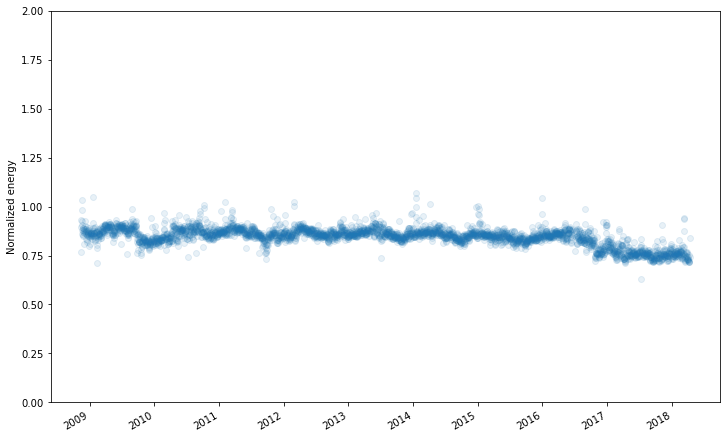

In [6]:
''' AGGRIGATE '''
# Aggregated on irradiance-weighted average
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation, frequency = 'D')
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')

Text(0.5, 0.98, 'Sensor-based degradation results')

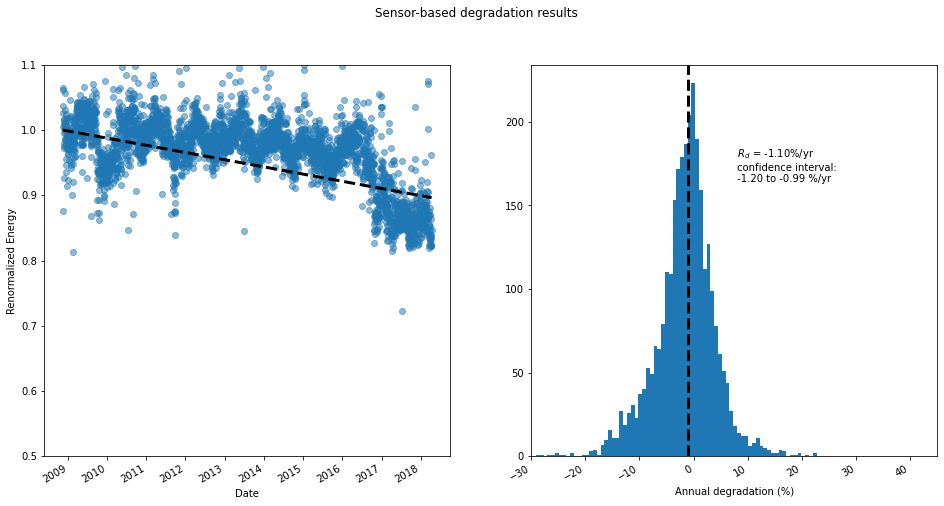

In [7]:
''' DEGRADATION CALC '''
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily, confidence_level=68.2)
start = daily.index[0]
end = daily.index[-1]
years = (end-start).days / 365.
yoy_values = yoy_info['YoY_values']
x = [start,end]
y = [1,1+(yoy_rd * years)/100]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax2.hist(yoy_values, label='YOY', bins=len(yoy_values)//40)
ax2.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate(u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(yoy_rd, yoy_ci[0], yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)')
ax1.plot(daily.index, daily/yoy_info['renormalizing_factor'],'o', alpha=0.5)
ax1.plot(x, y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()
fig.suptitle("Sensor-based degradation results")
